In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Gel_Project_Image_Classification

/content/drive/MyDrive/Gel_Project_Image_Classification


#1- Training the Model with a Single Linear Layer as the Classifier Head (single for shortcut)

#a1- Optimization Algorithm: Adam

In [ ]:
!python train.py --dataset_dir='/content/drive/MyDrive/Gel_Project_Image_Classification/dataset' --model_id=17 --hardware_type='gpu' --pretrained_model='vgg16' --classifier_head='single' --opt_alg='adam' --model_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/single-layer/Adam/model/gel_classifier-17.pth' --plots_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/single-layer/Adam/plots/loss_accuracy_plots/gel_classifier-17.png' --results_file='/content/drive/MyDrive/Gel_Project_Image_Classification/results.csv'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:05<00:00, 107MB/s]

[INFO] The full architecture of VGG16 model with the customized head:
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2

# Import the necessary libraries

In [ ]:
import os
import time
import torch
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import utils
import build_dataset
import prepare_model

#Loading and Preparing Test Dataset

In [ ]:
# Load the test images
test_images = '/content/drive/MyDrive/Gel_Project_Image_Classification/test_images'

# Create a test dataset
test_dataset = build_dataset.GelElectrophoresisDataset(test_images, transform=utils.test_transform)

# Get the number of classes
num_classes = test_dataset.num_classes

# Create dataloader on test images
test_dataloader = DataLoader(test_dataset, batch_size=23, shuffle=False, num_workers=2)

#Loading The Model

In [ ]:
def load_model(pretrained_model, classifier_head, hardware_type, num_classes, model_path):

    if pretrained_model == 'resnet18':
        model = prepare_model.resnet18(num_classes, classifier_head)
    elif pretrained_model == 'vgg16':
        model = prepare_model.vgg16(num_classes, classifier_head)
    elif pretrained_model == 'mobilenet-v3':
        model = prepare_model.mobilenet_v3(num_classes, classifier_head)
    else:
        raise ValueError("Invalid pretrained model")

    # Load the trained weights of the model from a saved checkpoint file
    model.load_state_dict(torch.load(model_path))

    print("[INFO] Loading the model...")

    # Choose the device to run inference on
    if hardware_type == 'gpu':
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            raise ValueError("GPU is not available. Please select 'cpu' as the hardware type.")
    elif hardware_type == 'cpu':
        device = torch.device('cpu')
    else:
        raise ValueError("Invalid hardware type. Please select either 'cpu' or 'gpu'.")

    # Move the model to the device
    model = model.to(device)

    # Set the model to evaluation mode
    model.eval()

    print("[INFO] Model loaded!")

    # Return the loaded model and device
    return model, device

In [ ]:
model, device=load_model('vgg16', 'single','gpu', num_classes, '/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/single-layer/Adam/model/gel_classifier-17.pth')

[INFO] Loading the model...
[INFO] Model loaded!


#Evaluate the model's performance on test images

In [ ]:
def evaluate_metrics(model, device, test_dataloader, model_id):

    # Testing loop
    predictions = []
    targets = []

    # Disables gradient calculation (as gradients are not needed during evaluation)
    with torch.no_grad():
      for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    conf_mat = confusion_matrix(targets, predictions)
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    print('[INFO] Accuracy: {:.2f}%'.format(accuracy*100))
    print('[INFO] Precision: {:.2f}%'.format(precision*100))
    print('[INFO] Recall: {:.2f}%'.format(recall*100))
    print('[INFO] Confusion matrix:\n', conf_mat)
    print('[INFO] AUC: {:.2f}%'.format(roc_auc*100))

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('ConfusionMatrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # Plot ROC curve
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.2f}%)'.format(roc_auc*100))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Store the evaluation metrics in a dictionary
    results = {
        'model_id': model_id,
        'accuracy': '{:.2f}%'.format(accuracy*100),
        'precision': '{:.2f}%'.format(precision*100),
        'recall': '{:.2f}%'.format(recall*100),
        'conf_mat': str(conf_mat.tolist()),
        'roc_auc': '{:.2f}%'.format(roc_auc*100)

    }

    return results

[INFO] Accuracy: 72.73%
[INFO] Precision: 82.35%
[INFO] Recall: 72.73%
[INFO] Confusion matrix:
 [[ 5  6]
 [ 0 11]]
[INFO] AUC: 72.73%


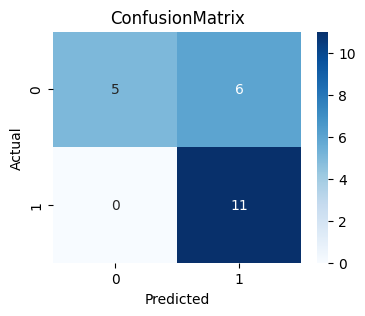

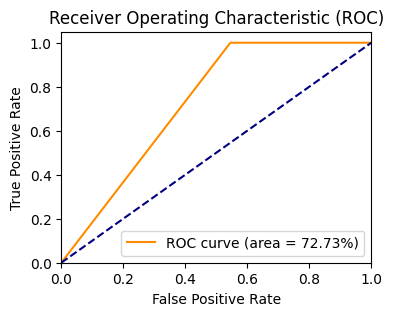

In [ ]:
results = evaluate_metrics(model, device, test_dataloader, 17)

In [ ]:
# Path to results CSV file
results_file='/content/drive/MyDrive/Gel_Project_Image_Classification/results.csv'

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Define the columns to update
columns_to_update = ['accuracy', 'precision', 'recall', 'conf_mat', 'roc_auc']

# Iterate over the columns to update and assign the corresponding values from the 'results' dictionary
for column in columns_to_update:
    results_df.loc[filter, column] = results[column]

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Evaluation metrics results saved in {results_file}")

[INFO] Evaluation metrics results saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#Model Inference on Test Images

In [ ]:
def inference(model, device, test_dataloader, test_dataset, model_id):
    # Start inference timer
    inf_start = time.time()

    # Testing loop
    predictions = []
    correct = 0
    total = 0

    # Disables gradient calculation (as gradients are not needed during inference)
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())

            # Display images with predicted and actual classes
            for j in range(len(labels)):
                # Get image name and path
                image_path = test_dataset.samples[j][0]
                image_name = os.path.basename(image_path)
                # Load and display image
                img = Image.open(image_path)
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.title(f'Predicted: {test_dataset.image_folder.classes[predictions[j]]}, Actual: {test_dataset.image_folder.classes[labels[j]]}')
                plt.show()

    # End inference timer
    inf_end = time.time()
    # Calculate inference time
    inf_time_secs = inf_end - inf_start
    # Convert seconds to minutes
    inf_time_mins = inf_time_secs / 60
    print("[INFO] Inference completed on test samples")
    # Print total inference time
    print(f"[INFO] Total inference time: {inf_time_secs:.2f} seconds, {inf_time_mins:.2f} minutes")

    # Store inference time in a dictionary
    results = {
      'model_id': model_id,
      'inference_time_secs': inf_time_secs
    }

    return results

In [ ]:
results = inference(model, device, test_dataloader, test_dataset, 17)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Update the 'inference_time_secs' column with the value from the 'results' dictionary
results_df.loc[filter, 'inference_time_secs'] = results['inference_time_secs']

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Inference time saved in {results_file}")

[INFO] Inference time saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#b1- Optimization Algorithm: SGD

In [ ]:
!python train.py --dataset_dir='/content/drive/MyDrive/Gel_Project_Image_Classification/dataset' --model_id=18 --hardware_type='gpu' --pretrained_model='vgg16' --classifier_head='single' --opt_alg='sgd' --model_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/single-layer/SGD/model/gel_classifier-18.pth' --plots_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/single-layer/SGD/plots/loss_accuracy_plots/gel_classifier-18.png' --results_file='/content/drive/MyDrive/Gel_Project_Image_Classification/results.csv'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

[INFO] The full architecture of VGG16 model with the customized head:
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

#Loading The Model

In [ ]:
model, device=load_model('vgg16', 'single','gpu', num_classes, '/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/single-layer/SGD/model/gel_classifier-18.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Loading the model...
[INFO] Model loaded!


#Evaluate the model's performance on test images

[INFO] Accuracy: 77.27%
[INFO] Precision: 79.46%
[INFO] Recall: 77.27%
[INFO] Confusion matrix:
 [[ 7  4]
 [ 1 10]]
[INFO] AUC: 77.27%


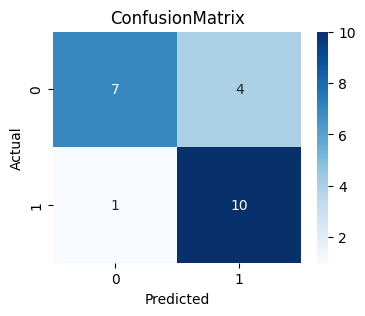

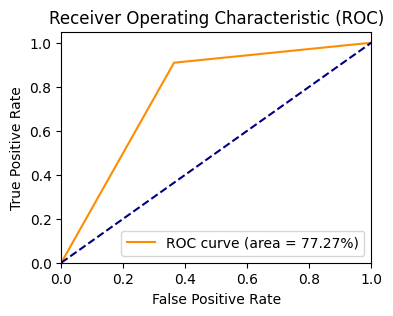

In [ ]:
results = evaluate_metrics(model, device, test_dataloader, 18)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Define the columns to update
columns_to_update = ['accuracy', 'precision', 'recall', 'conf_mat', 'roc_auc']

# Iterate over the columns to update and assign the corresponding values from the 'results' dictionary
for column in columns_to_update:
    results_df.loc[filter, column] = results[column]

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Evaluation metrics results saved in {results_file}")

[INFO] Evaluation metrics results saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#Model Inference on Test Images

In [ ]:
results = inference(model, device, test_dataloader, test_dataset, 18)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Update the 'inference_time_secs' column with the value from the 'results' dictionary
results_df.loc[filter, 'inference_time_secs'] = results['inference_time_secs']

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Inference time saved in {results_file}")

[INFO] Inference time saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#2- Training the Model with a Sequential Multi-Layer as the Classifier Head (multi for shortcut)

#a2- Optimization Algorithm: Adam

In [ ]:
!python train.py --dataset_dir='/content/drive/MyDrive/Gel_Project_Image_Classification/dataset' --model_id=19 --hardware_type='gpu' --pretrained_model='vgg16' --classifier_head='multi' --opt_alg='adam' --model_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/multi-layers/Adam/model/gel_classifier-19.pth' --plots_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/multi-layers/Adam/plots/loss_accuracy_plots/gel_classifier-19.png' --results_file='/content/drive/MyDrive/Gel_Project_Image_Classification/results.csv'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

[INFO] The full architecture of VGG16 model with the customized head:
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

#Loading The Model

In [ ]:
model, device=load_model('vgg16', 'multi', 'gpu', num_classes, '/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/multi-layers/Adam/model/gel_classifier-19.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Loading the model...
[INFO] Model loaded!


#Evaluate the model's performance on test images

[INFO] Accuracy: 77.27%
[INFO] Precision: 84.38%
[INFO] Recall: 77.27%
[INFO] Confusion matrix:
 [[ 6  5]
 [ 0 11]]
[INFO] AUC: 77.27%


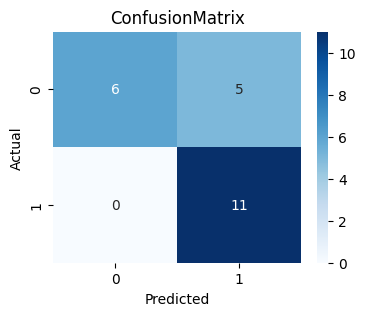

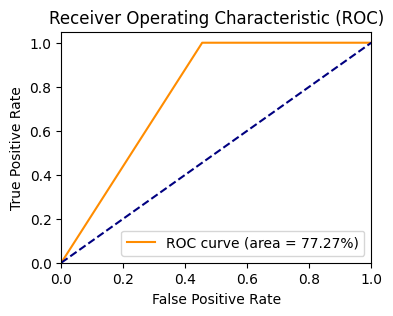

In [ ]:
results = evaluate_metrics(model, device, test_dataloader, 19)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Define the columns to update
columns_to_update = ['accuracy', 'precision', 'recall', 'conf_mat', 'roc_auc']

# Iterate over the columns to update and assign the corresponding values from the 'results' dictionary
for column in columns_to_update:
    results_df.loc[filter, column] = results[column]

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Evaluation metrics results saved in {results_file}")

[INFO] Evaluation metrics results saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#Model Inference on Test Images

In [ ]:
results = inference(model, device, test_dataloader, test_dataset, 19)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Update the 'inference_time_secs' column with the value from the 'results' dictionary
results_df.loc[filter, 'inference_time_secs'] = results['inference_time_secs']

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Inference time saved in {results_file}")

[INFO] Inference time saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#b2- Optimization Algorithm: SGD

In [ ]:
!python train.py --dataset_dir='/content/drive/MyDrive/Gel_Project_Image_Classification/dataset' --model_id=20 --hardware_type='gpu' --pretrained_model='vgg16' --classifier_head='multi' --opt_alg='sgd' --model_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/multi-layers/SGD/model/gel_classifier-20.pth' --plots_path='/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/multi-layers/SGD/plots/loss_accuracy_plots/gel_classifier-20.png' --results_file='/content/drive/MyDrive/Gel_Project_Image_Classification/results.csv'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

[INFO] The full architecture of VGG16 model with the customized head:
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

#Loading The Model

In [ ]:
model, device=load_model('vgg16', 'multi', 'gpu', num_classes, '/content/drive/MyDrive/Gel_Project_Image_Classification/GPU/VGG16/multi-layers/SGD/model/gel_classifier-20.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Loading the model...
[INFO] Model loaded!


#Evaluate the model's performance on test images

[INFO] Accuracy: 77.27%
[INFO] Precision: 79.46%
[INFO] Recall: 77.27%
[INFO] Confusion matrix:
 [[ 7  4]
 [ 1 10]]
[INFO] AUC: 77.27%


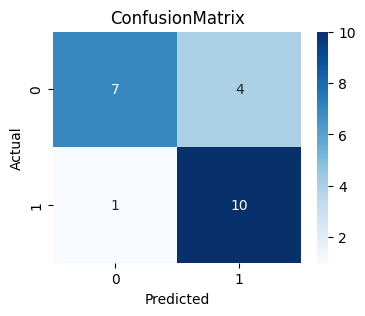

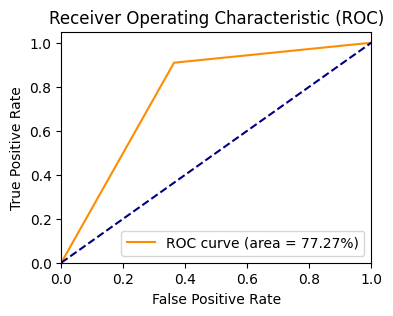

In [ ]:
results = evaluate_metrics(model, device, test_dataloader, 20)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Define the columns to update
columns_to_update = ['accuracy', 'precision', 'recall', 'conf_mat', 'roc_auc']

# Iterate over the columns to update and assign the corresponding values from the 'results' dictionary
for column in columns_to_update:
    results_df.loc[filter, column] = results[column]

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Evaluation metrics results saved in {results_file}")

[INFO] Evaluation metrics results saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv


#Model Inference on Test Images

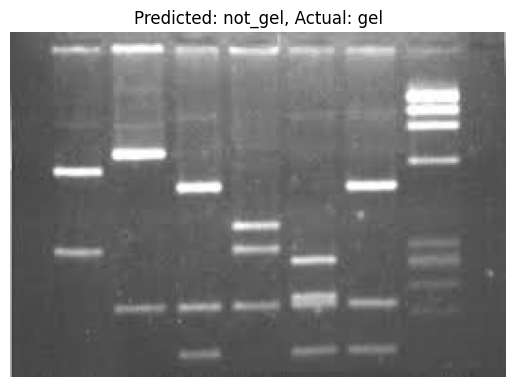

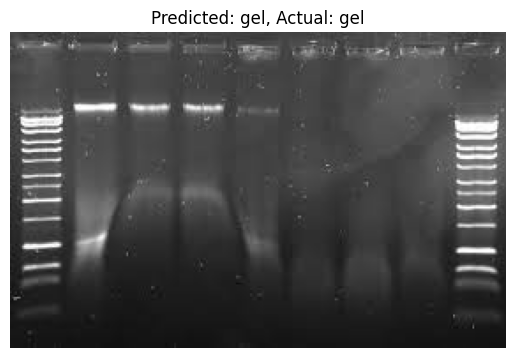

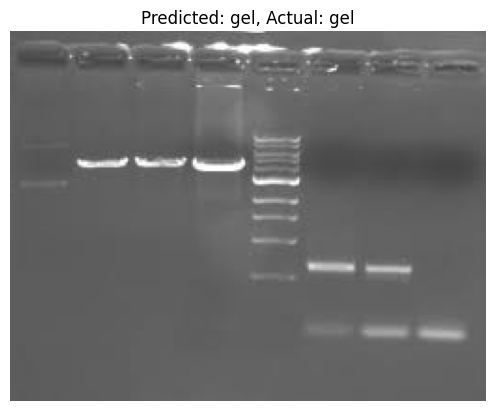

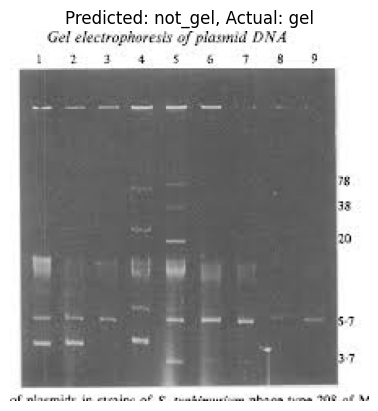

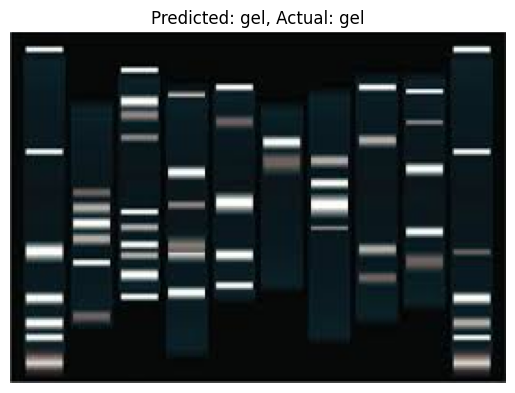

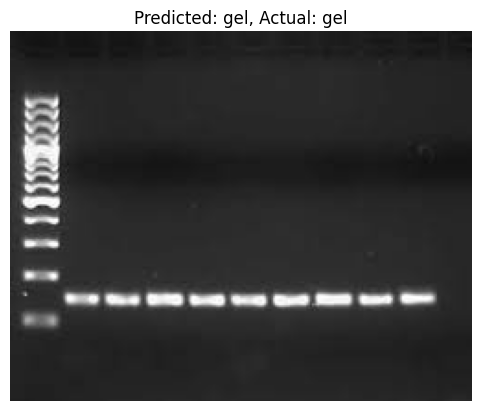

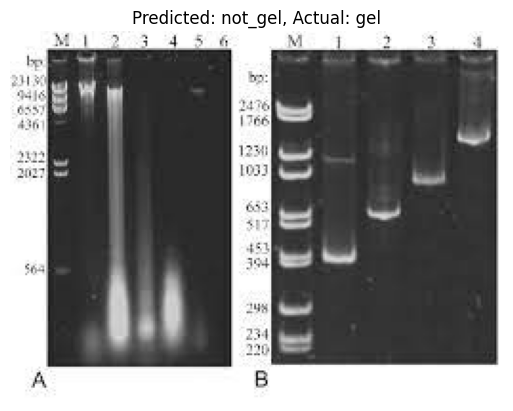

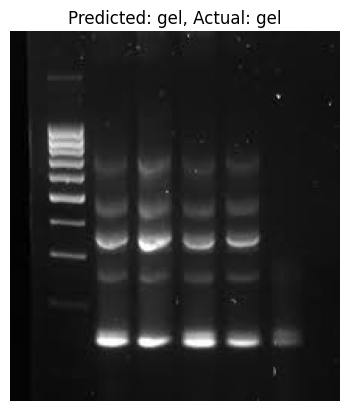

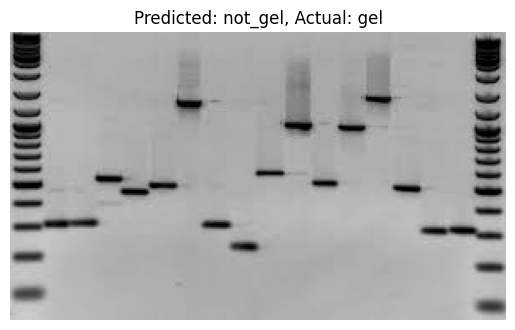

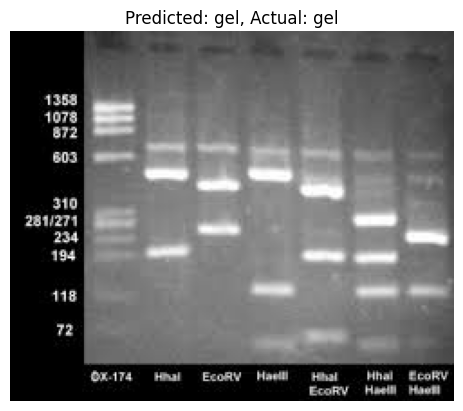

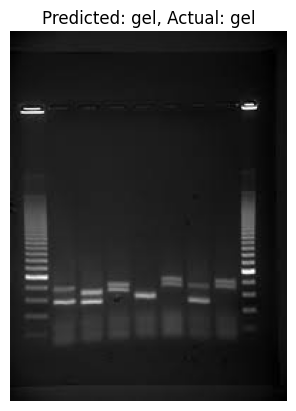

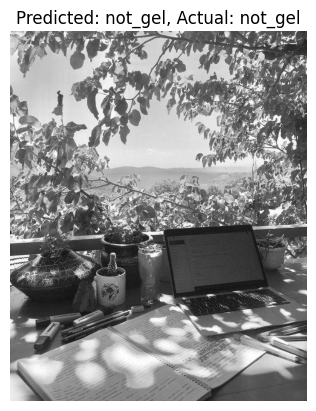

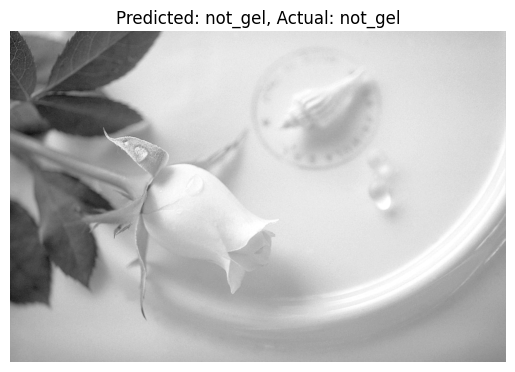

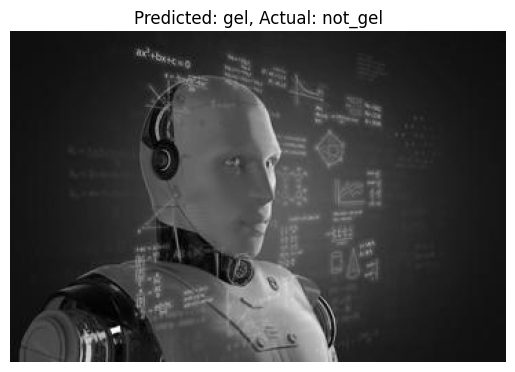

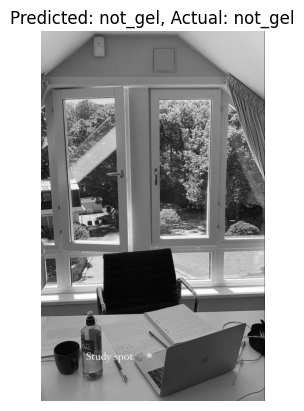

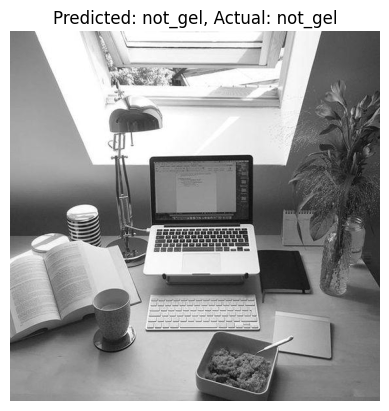

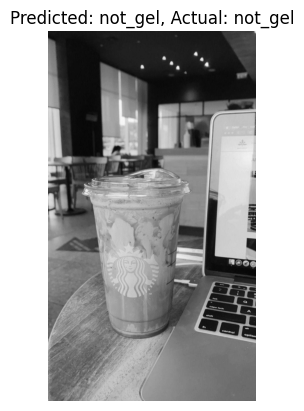

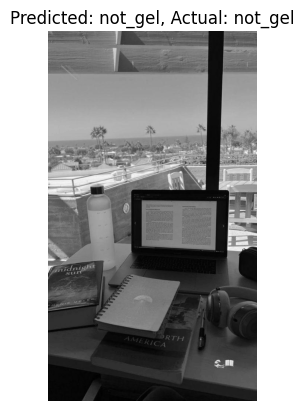

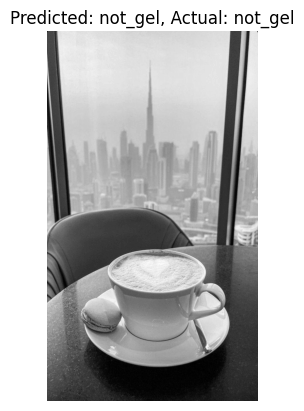

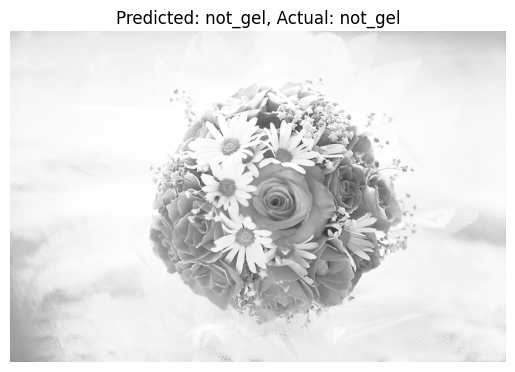

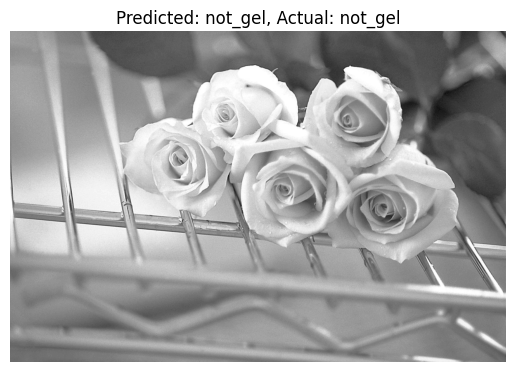

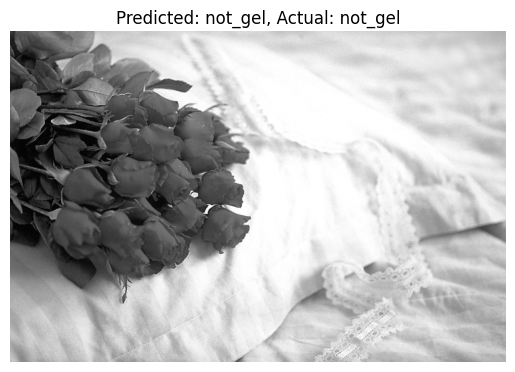

[INFO] Inference completed on test samples
[INFO] Total inference time: 6.44 seconds, 0.11 minutes


In [ ]:
results = inference(model, device, test_dataloader, test_dataset, 20)

In [ ]:
# Read the existing results.csv file into a DataFrame
results_df = pd.read_csv(results_file)

# Filter the DataFrame based on the 'model_id' column to locate the specific row to update
filter = results_df['model_id'] == results['model_id']

# Update the 'inference_time_secs' column with the value from the 'results' dictionary
results_df.loc[filter, 'inference_time_secs'] = results['inference_time_secs']

# Save the updated results DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)
print(f"[INFO] Inference time saved in {results_file}")

[INFO] Inference time saved in /content/drive/MyDrive/Gel_Project_Image_Classification/results.csv
